In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import utils as ut

system_name = 'kite3d_turboframe2'
run_name = 'sarsa2_a2'
data_dir = '../data/'+system_name+'/'+run_name+'/'
plot_dir = '../plots/'+system_name+'/'+run_name+'/'

## Learning of the 3d kite - relative velocity angle- with sarsa

In [48]:
env_params = ut.read_params(data_dir+'param_env.txt')
print(env_params)
alg_params = ut.read_params(data_dir+'param_alg.txt')
print(alg_params)

{'int_steps': 0.001, 'ep_length': 200.0, 'decision_time': 0.25, 'init_theta': 0.7853981633974483, 'init_dtheta': 0.0, 'init_phi': 0.0, 'init_dphi': 0.0, 'alphas': array([ 6.,  8., 10., 12., 14., 16., 18., 20.]), 'CL_alphas': array([0.65, 0.75, 0.82, 0.9 , 1.  , 1.08, 1.1 , 1.05]), 'CD_alphas': array([0.05, 0.07, 0.09, 0.1 , 0.13, 0.18, 0.18, 0.21]), 'init_alpha': 7.0, 'banks': array([-0.26179939, -0.20943951, -0.15707963, -0.10471976, -0.05235988,
        0.        ,  0.05235988,  0.10471976,  0.15707963,  0.20943951,
        0.26179939]), 'init_bank': 5.0, 'beta_bins': array([-3.14159265, -2.6927937 , -2.24399475, -1.7951958 , -1.34639685,
       -0.8975979 , -0.44879895,  0.        ,  0.44879895,  0.8975979 ,
        1.34639685,  1.7951958 ,  2.24399475,  2.6927937 ,  3.14159265]), 'wind_type': 'turboframe', 'wind_amplification': 1.3, 'windv_file_path': '../data/kite3d_turboframe/v.txt', 'windq_file_path': '../data/kite3d_turboframe/q.txt'}
{'alg_type': 'sarsa', 'gamma': 1.0, 'n_step

In [13]:
# ENVIRONMENT PARAMETERS
env_params = dict()
env_params['int_steps'] = 0.001 # sec
env_params['ep_length'] = 300 # sec
env_params['decision_time'] = 0.25 # sec
env_params['init_theta'] = np.pi/4 # rad
env_params['init_dtheta'] = 0 # rad
env_params['init_phi'] = 0 # rad
env_params['init_dphi'] = 0 # rad
# attack angles
env_params['alphas'] = [6,8,10,12,14,16,18,20]
env_params['CL_alphas'] = [0.65,0.75,0.82,0.9,1.0,1.08,1.1,1.05]
env_params['CD_alphas'] = [0.05,0.07,0.09,0.1,0.13,0.18,0.18,0.21]
env_params['init_alpha'] = len(env_params['alphas'])-1 # index, if larger than len it's random
# bank angles
env_params['banks'] = np.deg2rad([-15,-12,-9,-6,-3,0,3,6,9,12,15])
env_params['init_bank'] = int(len(env_params['banks'])/2) # index
# angle of relative velocity (bins)
env_params['beta_bins'] = np.linspace(-np.pi, np.pi, 15)
# wind
env_params['wind_type'] = 'turboframe'
env_params['wind_amplification'] = 1.3
env_params['windv_file_path'] = "../data/kite3d_turboframe/v.txt"
env_params['windq_file_path'] = "../data/kite3d_turboframe/q.txt"


# ALG PARAMETERS
alg_params = dict()
alg_params['alg_type'] = 'sarsa' # 'ac' for actor-critic, 'nac' for natural actor-critic
alg_params['gamma'] = 1.0
alg_params['n_steps'] = 5000000 # Number of training steps
print('Dynamical steps: ', alg_params['n_steps']*env_params['decision_time']/env_params['int_steps'])
print('Dynamical time, in seconds: ', alg_params['n_steps']*env_params['decision_time'])

alg_params['traj_points'] = 1
n_alphas=len(env_params['alphas'])
n_banks=len(env_params['banks'])
n_betas=len(env_params['beta_bins'])-1
alphas = [n_alphas-1]
banks = [n_banks-1]
alg_params['traj_states'] = [b + n_betas*(bank + n_banks*a) for b in range(n_betas) for a in alphas for bank in banks]

alg_params['init_q_path'] = '../data/kite3d_turboframe2/sarsa2/best_quality.txt' # Policy prior, comment for flat policy
alg_params['init_quals'] = 4000
# Learning rate
alg_params['lr0'] = 0.005
alg_params['lrc'] = alg_params['n_steps'] / 2000
alg_params['lr_expn'] = 0.8
alg_params['lr_burn'] = alg_params['n_steps']
# Exploration parameter
alg_params['eps0'] = 0.001
alg_params['epsc'] = alg_params['n_steps'] / 2000
alg_params['eps_expn'] = 0.8
alg_params['eps_burn'] = alg_params['n_steps']

Dynamical steps:  1250000000.0
Dynamical time, in seconds:  1250000.0


In [14]:
# WRITING THE PARAMETERS
ut.write_params(env_params, data_dir, 'param_env.txt')
ut.write_params(alg_params, data_dir, 'param_alg.txt')

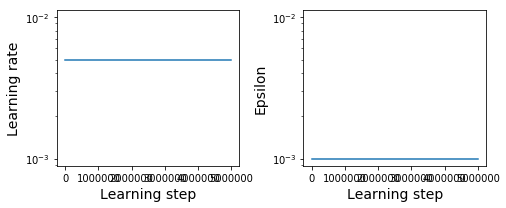

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,3))

ax1.set_xlabel('Learning step', fontsize=14)
ax1.set_ylabel('Learning rate', fontsize=14)
ax1.set_yscale('log')
#xs = np.linspace(0, alg_params['n_steps']/env_params['ep_length']*env_params['decision_time'], alg_params['traj_points'])
xs = np.linspace(0, alg_params['n_steps'], 100)
lr = [ut.p_law_burn(x, alg_params['lr_burn'], alg_params['lr_expn'], alg_params['lr0'], alg_params['lrc']) for x in xs]
ax1.plot(xs, lr)

ax2.set_xlabel('Learning step', fontsize=14)
ax2.set_ylabel('Epsilon', fontsize=14)
ax2.set_yscale('log')
eps = [ut.p_law_burn(x, alg_params['eps_burn'], alg_params['eps_expn'], alg_params['eps0'], alg_params['epsc']) for x in xs]
ax2.plot(xs, eps)

plt.tight_layout()
#plt.savefig(plot_dir+'lr.png', dpi=200)

In [16]:
import numpy as np
#v_traj = np.loadtxt(data_dir + system_name + '/' + run_name + '/value_traj.txt', dtype='float')
q_traj, s_labels, a_labels = ut.read_2d_traj(data_dir+'/quality_traj.txt')
r_traj, head = ut.read_traj(data_dir+'/return_traj.txt')

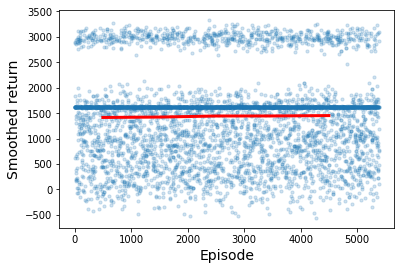

In [17]:
plt.xlabel('Episode', fontsize=14)
plt.ylabel('Smoothed return', fontsize=14)
#plt.ylim([-1000,3000])
x, y = ut.smooth_traj(r_traj[:,0], 1)
plt.scatter(x,y,s=10, alpha=0.2)
x, y = ut.smooth_traj(r_traj[:,0], 1000)
plt.plot(x,y, color='red', lw=3)

#plt.savefig(plot_dir+'return.png', dpi=200)

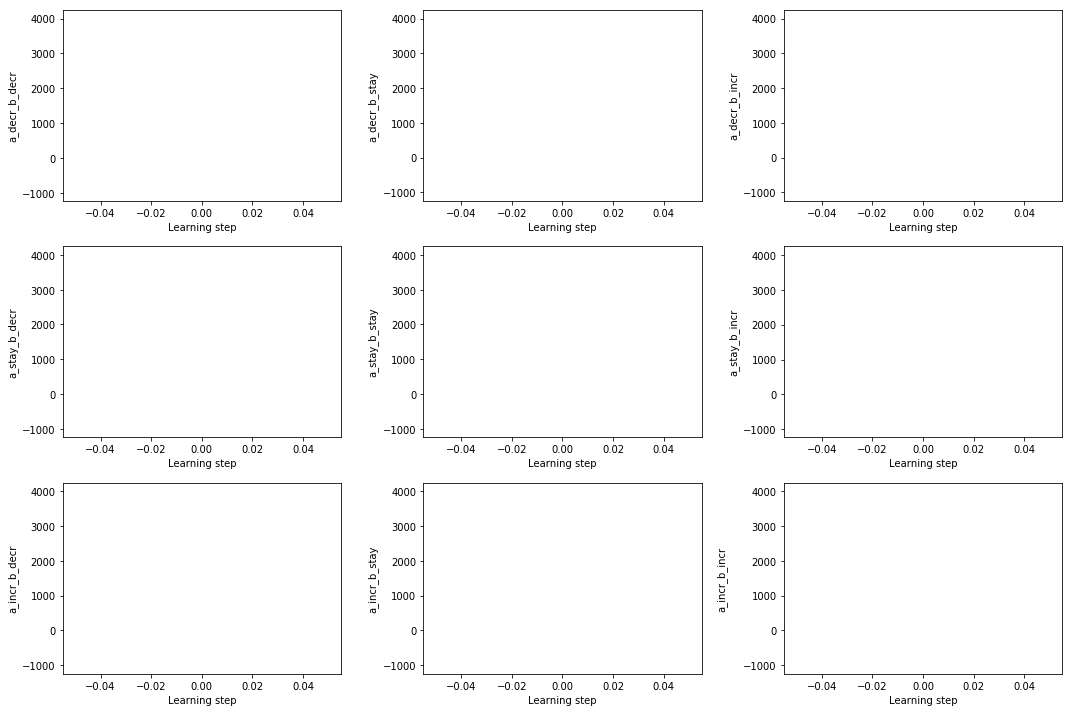

In [18]:
fig, axs = plt.subplots(3,3, figsize=(15,10))
colors = plt.cm.jet(np.linspace(0,1,len(alg_params['traj_states'])))
xs = np.linspace(0, alg_params['n_steps'] , alg_params['traj_points'] )

for a_ind in range(3):
    for b_ind in range(3):
        pl_ind = b_ind + 3*a_ind
        axs[a_ind][b_ind].set_xlabel('Learning step')
        axs[a_ind][b_ind].set_ylabel(a_labels[pl_ind])
        #ax1.set_xlim([0,alg_params['n_steps']])
        #ax1.set_ylim([-100,alg_params['init_values']])
        count=0
        for index in alg_params['traj_states']:
            axs[a_ind][b_ind].plot(xs, q_traj[:,count,pl_ind], label=s_labels[count], c=colors[count], lw=2)
            count += 1
#plt.legend()
plt.tight_layout()
#plt.savefig(plot_dir+'qualities.png', dpi=200)